**Objective:**
1. EDA analysis on the Heart disease dataset
2. Survivalbility models 
      **i)** Km model and log rank test, 
      **ii)** Cox model and analysing important covariates
3. Prediction of Survivability Function (using Cox)
4. Predicting age of a Healthy person to get heart disease (using Neural Network)
5. For a given feature values, predict if the person is having heart disease or not(using Lightgbm)

Note: comment section has futher explaination for each block

In [ ]:
#lifeline library for survival analytics
!pip install lifelines

In [ ]:
#importing necessary libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import lifelines
import math
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times, qth_survival_times
from keras.layers import Activation, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import statistics
from sklearn.model_selection import train_test_split
from lifelines.statistics import logrank_test


In [ ]:
#read the data
data=pd.read_csv('heart.csv')
print(data.shape)

(303, 14)


In [ ]:
#explore
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
#explore
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


# **Data Preprocessing and EDA**

In [ ]:
#handling missing data
data.sum().isnull()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

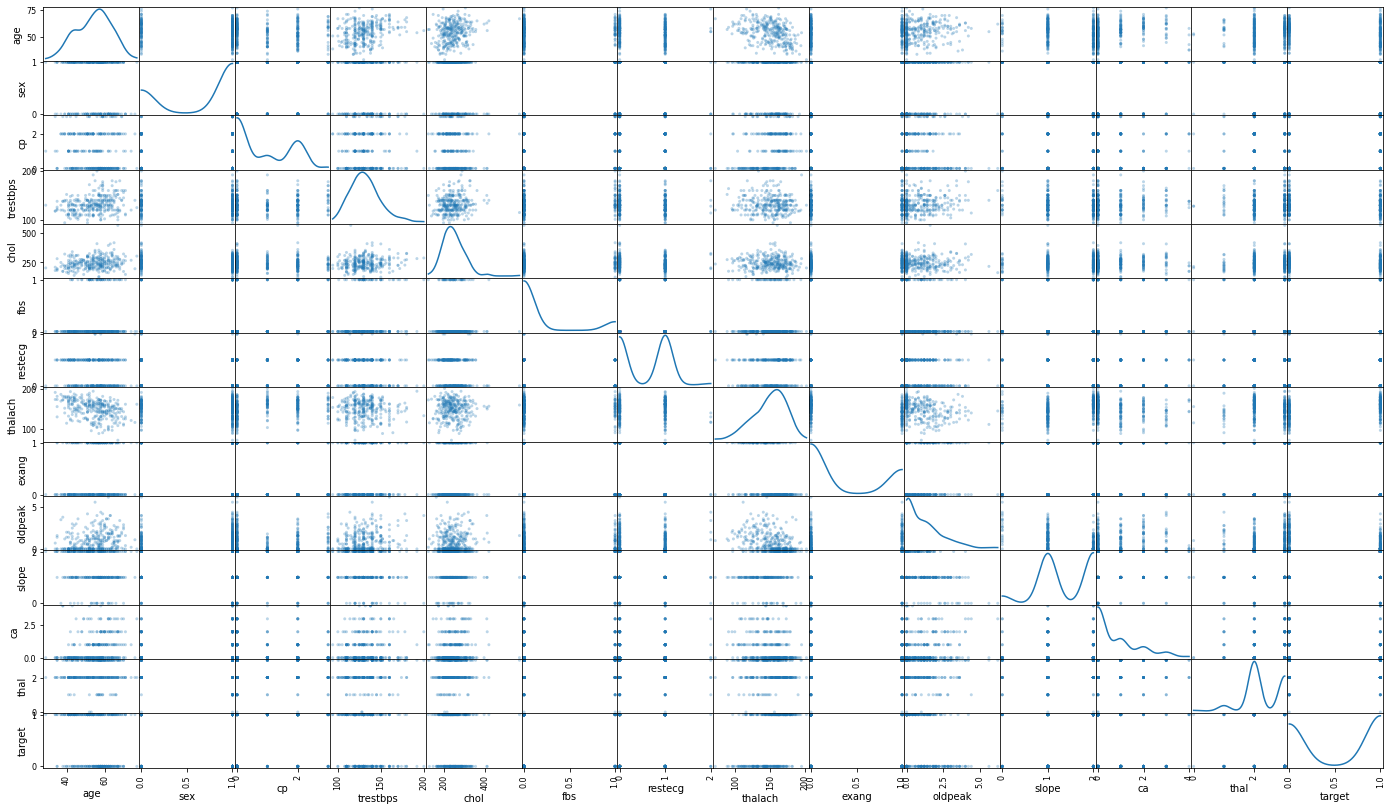

In [ ]:
#scatter plots between the variables to analyze the skewness of the feature values.
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (24,14), diagonal = 'kde');

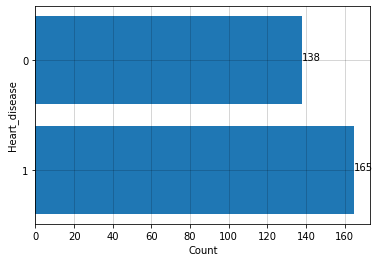

In [ ]:
#checking count of each class (almost balanced data)
plt.barh(list(map(str, list(data['target'].unique()))),data['target'].value_counts())
for index, value in enumerate(data['target'].value_counts()):
    plt.text(value, index, str(value))
plt.ylabel("Heart_disease")
plt.xlabel("Count")
plt.grid(b = True, color ='black',linestyle ='-', linewidth = 0.8,alpha = 0.2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


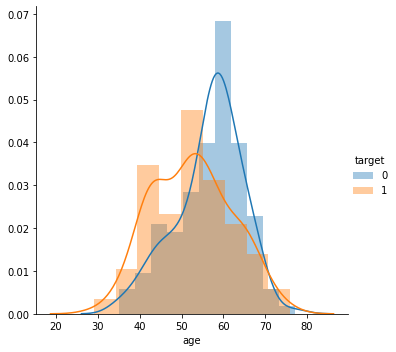

In [ ]:
#exploring the age distribution of patients with/without heart diseases
sns.FacetGrid(data, hue="target", height=5).map(sns.distplot, "age").add_legend();
plt.show()

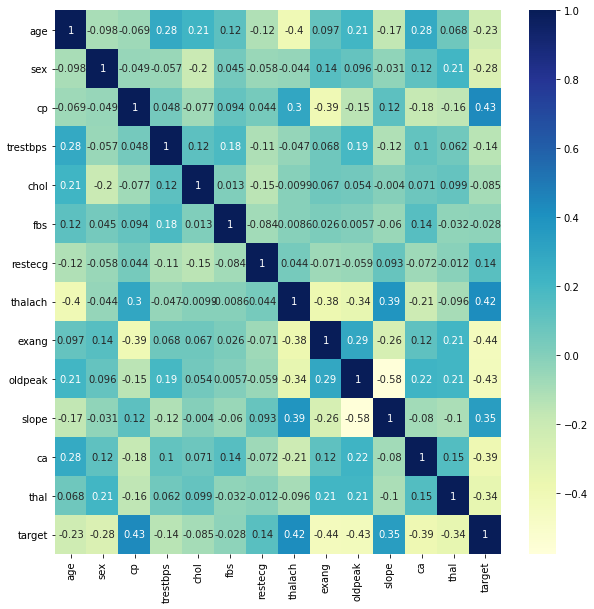

In [ ]:
#Correlation between variables
corr=data.corr()
plt.figure(figsize=(10,10)) 
sns.heatmap(corr,cmap='YlGnBu',annot=True)

# **Survival Models**
Kaplan Meier

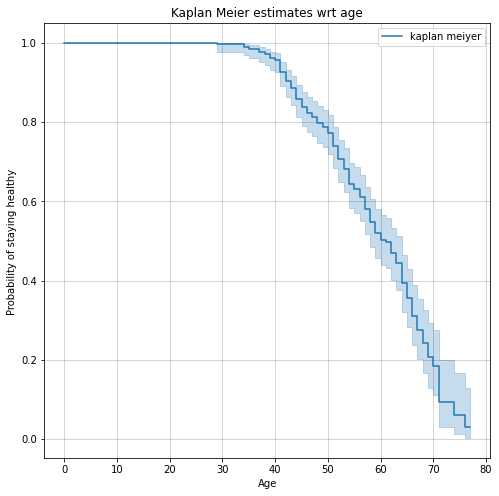

The Median survival time : 61.0 yrs


In [ ]:
#first we  do kaplan meier based only on the age
kmf = KaplanMeierFitter()
X=data['age']
Y=data['target']
kmf.fit(X, Y, label="kaplan meiyer")
plt.figure(figsize=(8,8))
kmf.plot()

plt.title("Kaplan Meier estimates wrt age")
plt.xlabel("Age")
plt.ylabel("Probability of staying healthy ")
plt.grid(b = True, color ='black',linestyle ='-', linewidth = 0.8,alpha = 0.2)
plt.show()
print("The Median survival time :",kmf.median_survival_time_,"yrs")

In [ ]:
# Performing log rank test on two different age groups to check for significant difference.
age_g1 = data[(data['age'] > 20) & (data['age'] <= 50)]
age_g2 = data[(data['age'] > 50) & (data['age'] <= 80)]
results=logrank_test(age_g1['age'],age_g2['age'],event_observed_A=age_g1['target'], event_observed_B=age_g2['target'])
results.print_summary()
#Based on this we can say that the age group plays a vital role in survivability

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         286.42 <0.005    211.02

Cox hazard model

In [ ]:
#cox hazard , weights of each feature 
cph = CoxPHFitter()
cph.fit(data, duration_col='age',  event_col='target')
ht=cph.baseline_cumulative_hazard_
print("Score:",cph.score(data))
cph.print_summary()

Score: -2.287019638936063


<lifelines.CoxPHFitter: fitted with 303 total observations, 138 right-censored observations>
             duration col = 'age'
                event col = 'target'
      baseline estimation = breslow
   number of observations = 303
number of events observed = 165
   partial log-likelihood = -692.97
         time fit was run = 2021-04-20 06:42:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.07       0.93       0.18            -0.42             0.28                 0.65                 1.32
cp          0.22       1.24       0.08             0.05             0.38                 1.05                 1.47
trestbps   -0.02       0.98       0.01            -0.03            -0.01                 0.97                 0.99
chol       -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
fbs        -0.12       0.89       0.24            -0.58             0.35                 0.56                 1.41
restecg     0.22       1.25       0.16            -0.08             0.53                 0.92                 1.70
thalach     0.04       1.04       0.01             0.03             0.05                 1.03                 1.05
exang      -0.25       0.78       0.24            -0.73             0.22                 0.48                 1.25
oldpeak    -0.22       0.80       0.13            -0.47             0.03                 0.63                 1.03
slope       0.18       1.20       0.17            -0.15             0.52                 0.86                 1.67
ca         -0.69       0.50       0.12            -0.93            -0.44                 0.39                 0.64
thal       -0.28       0.76       0.16            -0.60             0.04                 0.55                 1.04

              z      p   -log2(p)
covariate                        
sex       -0.41   0.68       0.55
cp         2.57   0.01       6.63
trestbps  -4.61 <0.005      17.90
chol      -2.98 <0.005       8.42
fbs       -0.49   0.62       0.68
restecg    1.43   0.15       2.72
thalach    7.07 <0.005      39.21
exang     -1.05   0.30       1.76
oldpeak   -1.75   0.08       3.64
slope      1.09   0.27       1.87
ca        -5.52 <0.005      24.80
thal      -1.73   0.08       3.59
---
Concordance = 0.83
Partial AIC = 1409.93
log-likelihood ratio test = 221.26 on 12 df
-log2(p) of ll-ratio test = 132.50

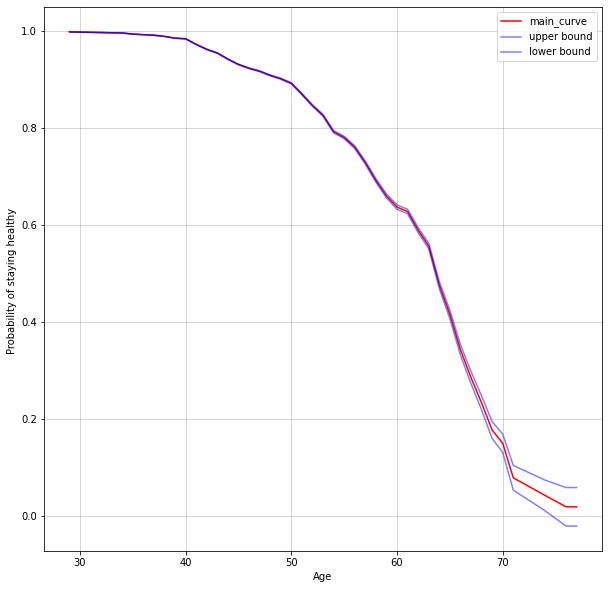

In [ ]:
#Cox curve with cofidence interval
ht['curve']=cph.baseline_survival_.values
ht['er_sup']=ht['curve']+(ht['baseline cumulative hazard']/100)
ht['er_inf']=ht['curve']-(ht['baseline cumulative hazard']/100)
plt.figure(figsize=(10,10))
ht['curve'].plot(color='r',label='main_curve')
ht['er_sup'].plot(color='b',alpha=0.5,label='upper bound')
ht['er_inf'].plot(color='b',alpha=0.5,label='lower bound')
plt.xlabel("Age")
plt.ylabel("Probability of staying healthy ")
plt.legend()
plt.grid(b = True, color ='black',linestyle ='-', linewidth = 0.8,alpha = 0.2)
plt.show()

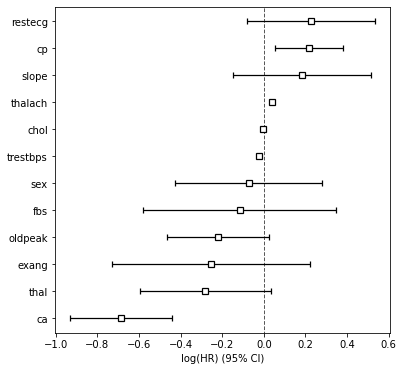

In [ ]:
#pictorial representation of coefficient of each variable
plt.figure(figsize=(6,6))
cph.plot()

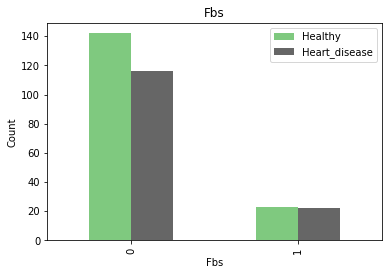

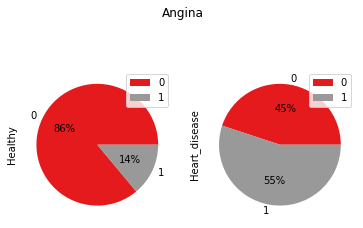

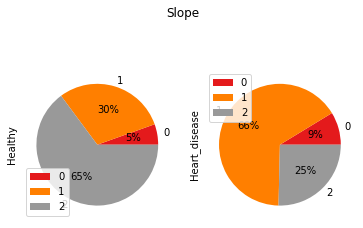

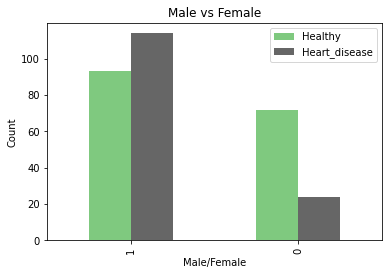

In [ ]:
#exploring the huge factor (fbs here)
fbs_1=data['fbs'].loc[data['target']==0].value_counts()
fbs_2=data['fbs'].loc[data['target']==1].value_counts()
data_fbs=pd.DataFrame({'Healthy':fbs_2,'Heart_disease':fbs_1})
data_fbs.plot.bar(title='Fbs',colormap='Accent')
plt.xlabel("Fbs")
plt.ylabel("Count")
plt.show()

#studying angina pectoris's effect
exang_1=data['exang'].loc[data['target']==0].value_counts()
exang_2=data['exang'].loc[data['target']==1].value_counts()
data_exang=pd.DataFrame({'Healthy':exang_2,'Heart_disease':exang_1})
data_exang.plot.pie(subplots=True,colormap='Set1',autopct='%.0f%%',label='',title='Angina')

slope_1=data['slope'].loc[data['target']==0].value_counts()
slope_2=data['slope'].loc[data['target']==1].value_counts()
data_slope=pd.DataFrame({'Healthy':slope_2,'Heart_disease':slope_1})
data_slope.plot.pie(subplots=True,colormap='Set1',autopct='%.0f%%',label='',title ='Slope')

sex_1=data['sex'].loc[data['target']==0].value_counts()
sex_2=data['sex'].loc[data['target']==1].value_counts()
data_sex=pd.DataFrame({'Healthy':sex_2,'Heart_disease':sex_1})
data_sex.plot.bar(colormap='Accent',label='',title ='Male vs Female')
plt.xlabel("Male/Female")
plt.ylabel("Count")
plt.show()

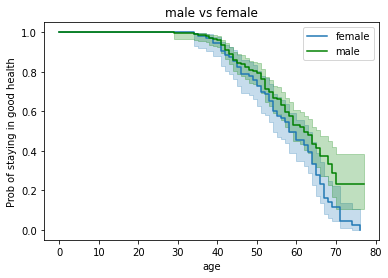

In [ ]:
#Km wrt to gender 
sat_1=data[['sex','age','target']].loc[data['sex']==0]
sat_2=data[['sex','age','target']].loc[data['sex']==1]

kmf = KaplanMeierFitter()
kmf.fit(sat_1['age'], sat_1['target'], label="kmf.plot()")
kmf.plot(label='female')

kmf = KaplanMeierFitter()
kmf.fit(sat_2['age'], sat_2['target'], label="kmf.plot()")
kmf.plot(color='g',label='male')
plt.title("male vs female")
plt.xlabel("age")
plt.ylabel("Prob of staying in good health")
plt.show()
#analysis from the plot contradicts the observation derived from the above bar graph

<Figure size 864x864 with 0 Axes>

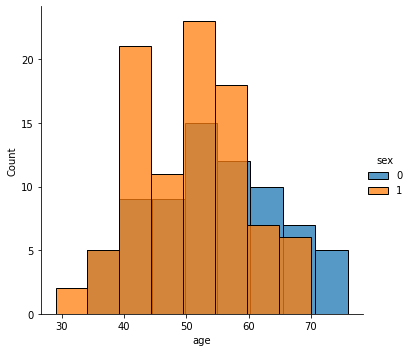

In [ ]:
# analysing the gender distribution wrt to gender
ast=data[['age','sex']].loc[data['target']==1]
plt.figure(figsize=(12,12))
sns.FacetGrid(ast, hue="sex", height=5).map(sns.histplot, "age").add_legend().set(xlabel='age',ylabel='Count');


# **Survivability Function Prediction**


In [ ]:
#pred, refers to a healthy person with no heart disease, a vector of all the features
#[age,sex,chest pain,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal]
pred=np.array([24,0,0,130,170,0,0,120,0,0.62,1,0,3,0])
data.loc[-1] = pred
data.tail(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
301,57.0,1.0,0.0,130.0,131.0,0.0,1.0,115.0,1.0,1.20,1.0,1.0,3.0,0.0
302,57.0,0.0,1.0,130.0,236.0,0.0,0.0,174.0,0.0,0.00,1.0,1.0,2.0,0.0
-1,24.0,0.0,0.0,130.0,170.0,0.0,0.0,120.0,0.0,0.62,1.0,0.0,3.0,0.0


In [ ]:
#censored subjects are one which is yet to have a heart disease
#unconditiond sf's are used such that these censored subjects will undergo some event in a given time
cph = CoxPHFitter()
cph.fit(data, duration_col='age',  event_col='target')
censored_subjects = data.loc[data['target'] == 0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)
print(unconditioned_sf.head(3))

           165       166       167  ...       301       302      -1  
24.0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000
29.0  0.999989  0.999905  0.999799  ...  0.999763  0.996703  0.999404
34.0  0.999967  0.999709  0.999388  ...  0.999278  0.989975  0.998182

[3 rows x 139 columns]


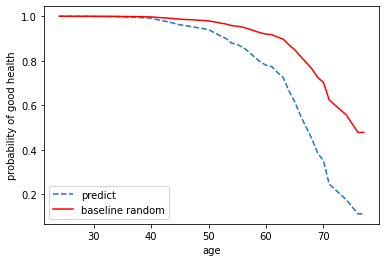

In [ ]:
#plotting the predicted survival function
pl=unconditioned_sf[-1].plot(ls='--',label='predict')
unconditioned_sf[167].plot(color='r',ax=pl,label='baseline random')
pl.set(xlabel='age', ylabel='probability of good health')
pl.legend()

In [ ]:
#threshold to define when a healthy person's heart will have problem
q3_pred = qth_survival_times(0.75, unconditioned_sf)
q1_pred = qth_survival_times(0.25, unconditioned_sf)
q2_pred = median_survival_times(unconditioned_sf)

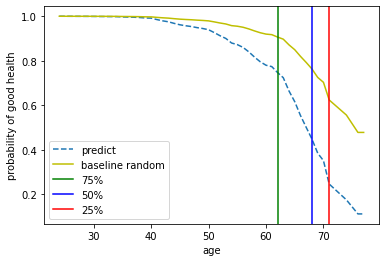

In [ ]:
#plotting the predicted survival function wrt to the thresold of getting a heart disease
pl_thres=unconditioned_sf[-1].plot(ls='--',label='predict')
unconditioned_sf[167].plot(color='y',label='baseline random',ax=pl_thres)
plt.axvline((q3_pred[-1].values), 0,1,color='g',label='75%')
plt.axvline((q2_pred[-1].values), 0,1,color='b',label='50%')
plt.axvline((q1_pred[-1].values), 0,1,color='r',label='25%')
pl_thres.set(xlabel='age', ylabel='probability of good health')
pl_thres.legend()

# **Prediction of heart disease**
Artificial Neural Network

In [ ]:
#data train must be done on the data that already have a target value of 1
data_train=(data.loc[data['target']==1]).copy()
data_train.drop(['target'],1,inplace=True)
X_column=[c for c in data_train.columns if c not in ['age']]
Y_column=['age']
data_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0


In [ ]:
#NN model
NN_model = Sequential()
NN_model.add(Dense(32, kernel_initializer='normal'))
NN_model.add(Dense(1, kernel_initializer='normal'))    
NN_model.add(Activation('linear'))
NN_model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])

In [ ]:
#training and validating the NN model
x_train, x_val, y_train, y_val=train_test_split(data_train[X_column].values, data_train[Y_column].values , test_size=0.33, random_state=4)
history=NN_model.fit(x_train, y_train, epochs=50, batch_size=10)
preds = NN_model.predict(x_val) 
score = math.sqrt(mean_squared_error(y_val, preds))
print("SCORE:",score)

Epoch 1/50
11/11 [==============================] - 0s 2ms/step - loss: 2369.0366 - root_mean_squared_error: 48.6453
Epoch 2/50
11/11 [==============================] - 0s 2ms/step - loss: 1289.3570 - root_mean_squared_error: 35.8837
Epoch 3/50
11/11 [==============================] - 0s 1ms/step - loss: 541.8402 - root_mean_squared_error: 23.2330
Epoch 4/50
11/11 [==============================] - 0s 1ms/step - loss: 139.4259 - root_mean_squared_error: 11.7972
Epoch 5/50
11/11 [==============================] - 0s 2ms/step - loss: 96.9535 - root_mean_squared_error: 9.8332
Epoch 6/50
11/11 [==============================] - 0s 2ms/step - loss: 114.9193 - root_mean_squared_error: 10.6184
Epoch 7/50
11/11 [==============================] - 0s 1ms/step - loss: 110.3159 - root_mean_squared_error: 10.4907
Epoch 8/50
11/11 [==============================] - 0s 2ms/step - loss: 99.4758 - root_mean_squared_error: 9.9558
Epoch 9/50
11/11 [==============================] - 0s 2ms/step - loss: 11

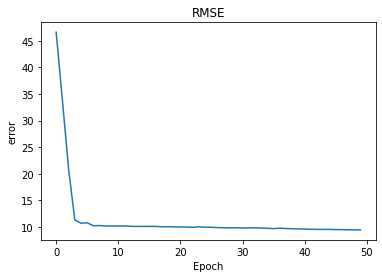

In [ ]:
#plotting the loss and rmse values wrt epoch
plt.plot(history.history['root_mean_squared_error'])
plt.xlabel("Epoch")
plt.ylabel('error')
plt.title('RMSE')
plt.show()

In [ ]:
#prediction of age
predict=np.array([1,0,130,170,0,0,120,0,0.62,1,0,3,0])

data_test=(data.loc[data['target']==0]).copy()
data_test.drop(['target'],1,inplace=True)
data_test.loc[-1] = predict
predicted_age = NN_model.predict(data_test[X_column].values)

In [ ]:
print("A heart diseases will appear at the age of: {}".format(predicted_age[-1]))

A heart diseases will appear at the age of: [69.76051]


# **Predict if someone have disease**
Light Gradient Boosting Machine

In [ ]:
feature=[c for c in data_train.columns if c not in ['target']]
target=data['target']

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
predict = np.zeros(len(data))
feature_importance_df = pd.DataFrame()

In [ ]:
param={
       'bagging_fraction': 0.33,
       'boost_from_average':'false',
       'boost': 'gbdt',
       'max_depth': -1,
       'metric':'auc',
       'objective': 'binary',
       'verbosity': 1
    }

In [ ]:
#uses light gbm to train and valid the model and finds feature importance
for fold_, (trn_idx, val_idx) in enumerate(folds.split(data.values, target.values)):

    trn_data = lgb.Dataset(data.iloc[trn_idx][feature], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(data.iloc[val_idx][feature], label=target.iloc[val_idx])

    num_round = 500
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 50)
    predict[val_idx] = clf.predict(data.iloc[val_idx][feature], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feature
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, predict)))

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[9]	training's auc: 0.958	valid_1's auc: 0.89916
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	training's auc: 0.957405	valid_1's auc: 0.92437
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.952784	valid_1's auc: 0.922269
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.958	valid_1's auc: 0.901261
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[31]	training's auc: 0.983591	valid_1's auc: 0.941176
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.949852	valid_1's auc: 0.801339
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	tra

In [ ]:
feature_importance_df

,Feature,importance,fold
0,age,11,1
1,sex,4,1
2,cp,9,1
3,trestbps,1,1
4,chol,6,1
...,...,...,...
8,exang,5,10
9,oldpeak,20,10
10,slope,7,10
11,ca,22,10


Text(0.5, 1.0, 'LightGBM Features (average_for_all_fold)')

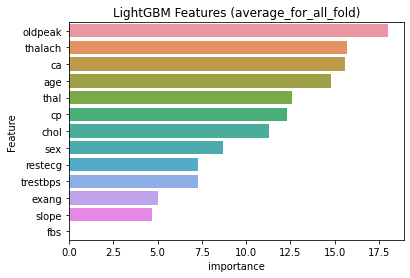

In [ ]:
try1=feature_importance_df.groupby(['Feature'],as_index=False).mean()
try1.drop(['fold'],1,inplace=True)

sns.barplot(x="importance", y="Feature", data=try1.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (average_for_all_fold)')

In [ ]:
predict_=np.array([[24,1,0,130,170,0,0,120,0,0.62,1,0,3]])
compare_random=data.iloc[1][feature]
disease_predict=clf.predict(predict_,num_iteration=clf.best_iteration)
disease_random=clf.predict(compare_random,num_iteration=clf.best_iteration)
print("Predicted result : {}".format(disease_predict))
print("Random result    : {}".format(disease_random))

Predicted result : [0.51017061]
Random result    : [0.85832896]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
